In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent.parent))

In [2]:
# experiments
from experiments.run_sweep import run_sweep
from experiments.run_experiment import TrainingConfig, EvaluateConfig
from experiments.sweep_plots import plot_sweep_training, plot_sweep_evaluation
from experiments.sweep_plots_helper import frozenlake_training_plot_specs, frozenlake_evaluation_plot_specs

# environments
from environments.fronzenlake import FrozenLakeConfig, get_frozenlake_env

# SARSA confirmation bias agent
from agents.sarsa_td0_confirmation_bias import (
    SarsaTD0ConfirmationBiasConfig,
    SarsaTD0ConfirmationBiasAgent,
)

# metrics for training
from metrics.reward_mertrics import frozenlake_reward_metrics_specs
from metrics.frustration_metrics import frustration_metrics_specs

# external libraries
import numpy as np

In [13]:
from __future__ import annotations

import math
from typing import Any, Iterable


def _agent_kwargs_from_result(result: dict[str, Any]) -> dict[str, Any]:
    params = result.get("params", {}) or {}
    agent_kwargs = params.get("agent_kwargs", {}) or {}
    # Support both direct dict and {"config": {...}} style.
    if (
        isinstance(agent_kwargs, dict)
        and "config" in agent_kwargs
        and isinstance(agent_kwargs["config"], dict)
    ):
        return agent_kwargs["config"]
    return agent_kwargs


def _pair_matches(
    value_pair: tuple[float, float],
    allowed_pairs: Iterable[tuple[float, float]],
    tol: float,
) -> bool:
    a, b = value_pair
    return any(
        math.isclose(a, x, abs_tol=tol, rel_tol=0.0)
        and math.isclose(b, y, abs_tol=tol, rel_tol=0.0)
        for x, y in allowed_pairs
    )


def _result_seed(result: dict[str, Any]) -> int | None:
    params = result.get("params", {}) or {}
    agent_kwargs = params.get("agent_kwargs", {}) or {}
    env_kwargs = params.get("env_kwargs", {}) or {}

    seed = agent_kwargs.get("seed")
    if seed is None:
        seed = env_kwargs.get("seed")
    if seed is None:
        seed = params.get("seed")

    return int(seed) if seed is not None else None


def select_results(
    results: list[dict[str, Any]],
    ac_ad_pairs: Iterable[tuple[float, float]] | None = None,
    ap_an_pairs: Iterable[tuple[float, float]] | None = None,
    positivity_ratios: Iterable[float] | None = None,
    seeds: Iterable[int] | None = None,  # NEW: list of seeds
    tol: float = 1e-9,
) -> list[dict[str, Any]]:
    ac_ad_pairs = list(ac_ad_pairs or [])
    ap_an_pairs = list(ap_an_pairs or [])
    positivity_ratios = list(positivity_ratios or [])
    seed_set = {int(s) for s in (seeds or [])}

    # No filters at all
    if not ac_ad_pairs and not ap_an_pairs and not positivity_ratios and not seed_set:
        return list(results)

    out: list[dict[str, Any]] = []
    for r in results:
        # Seed filter (ANDed)
        if seed_set:
            rs = _result_seed(r)
            if rs is None or rs not in seed_set:
                continue

        # If only seed filter is used
        if not ac_ad_pairs and not ap_an_pairs and not positivity_ratios:
            out.append(r)
            continue

        ak = _agent_kwargs_from_result(r)
        matched = False

        if ac_ad_pairs:
            ac = ak.get("alpha_conf")
            ad = ak.get("alpha_disconf")
            if (
                ac is not None
                and ad is not None
                and _pair_matches((float(ac), float(ad)), ac_ad_pairs, tol)
            ):
                matched = True

        if not matched and ap_an_pairs:
            ap = ak.get("alpha_positive")
            an = ak.get("alpha_negative")
            if (
                ap is not None
                and an is not None
                and _pair_matches((float(ap), float(an)), ap_an_pairs, tol)
            ):
                matched = True

        if not matched and positivity_ratios:
            ap = ak.get("alpha_positive")
            an = ak.get("alpha_negative")
            if ap is not None and an is not None:
                ap = float(ap)
                an = float(an)
                if not math.isclose(an, 0.0, abs_tol=tol, rel_tol=0.0):
                    ratio = ap / an
                    if any(
                        math.isclose(ratio, target, abs_tol=tol, rel_tol=0.0)
                        for target in positivity_ratios
                    ):
                        matched = True

        if matched:
            out.append(r)

    return out

In [3]:
BASE_AGENT_CONFIG_CONF = dict(
    alpha_conf=0.2,
    alpha_disconf=0.2,
    gamma=0.99,
    epsilon=0.2,
    reward_metrics=frozenlake_reward_metrics_specs(),
    td_error_metrics=frustration_metrics_specs(),
)


BASE_AGENT_CONFIG_POSITITY = dict(
    alpha_positive=0.2,
    alpha_negative=0.2,
    gamma=0.99,
    epsilon=0.2,
    reward_metrics=frozenlake_reward_metrics_specs(),
    td_error_metrics=frustration_metrics_specs(),
)

## Environments

In [4]:
env_config = FrozenLakeConfig(is_slippery=True)

## Agents

In [5]:
## Agents
# sarsa_td0 confirmation bias agent
agent_factory = SarsaTD0ConfirmationBiasAgent

sarsa_td0_config = SarsaTD0ConfirmationBiasConfig(**BASE_AGENT_CONFIG_CONF)

## Sweep configuration

In [6]:
base_train = TrainingConfig(
    name="FrozenLake_sarsa_td0",
    num_train_episodes=35000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="FrozenLake_sarsa_td0",
    num_eval_episodes=5000,  # use >0 if you want eval outputs
    env_kwargs={"config": env_config},
    evaluation_metrics=frozenlake_reward_metrics_specs(),
)

## Confirmation bias results

In [7]:
def generate_alpha_pairs(
    balanced_lr: float | list[float], num_pairs: int, step_size: float
):
    lrs = balanced_lr if isinstance(balanced_lr, list) else [balanced_lr]

    all_confirmatory_pairs = []
    all_balanced_pairs = []
    all_disconfirmatory_pairs = []

    for lr in lrs:
        confirmatory_pairs = [
            (round(lr + k * step_size, 3), round(lr - k * step_size, 3))
            for k in range(1, num_pairs + 1)
        ]
        balanced_pairs = [(round(lr, 3), round(lr, 3))]
        disconfirmatory_pairs = [
            (round(lr - k * step_size, 3), round(lr + k * step_size, 3))
            for k in range(1, num_pairs + 1)
        ]

        # Highest confirmatory lr first
        confirmatory_pairs.sort(key=lambda p: p[0], reverse=True)

        all_confirmatory_pairs.extend(confirmatory_pairs)
        all_balanced_pairs.extend(balanced_pairs)
        all_disconfirmatory_pairs.extend(disconfirmatory_pairs)

    return all_confirmatory_pairs, all_balanced_pairs, all_disconfirmatory_pairs

In [8]:
# different q_tables
env = get_frozenlake_env(env_config)

In [17]:
# create different initial q_tables for the sweep
num_states = env.observation_space.n
num_actions = env.action_space.n

# q table initializations
q0 = np.zeros((num_states, num_actions), dtype=np.float64)
q_pos = np.ones((num_states, num_actions), dtype=np.float64)
q_neg = np.ones((num_states, num_actions), dtype=np.float64) * -1

q_tables = [("zeros", q0)]

confirmatory_pairs, balanced_pairs, disconfirmatory_pairs = generate_alpha_pairs(
    balanced_lr=[0.2], num_pairs=5, step_size=0.025
)

alpha_pairs = confirmatory_pairs + balanced_pairs + disconfirmatory_pairs
seeds = list(range(2))  # 20 different seeds

sweep = {
    "agent_kwargs": [
        {
            "alpha_conf": a_conf,
            "alpha_disconf": a_disconf,
            "seed": seed,
            "initial_q_table": q_table,
            "initial_q_table_label": label,
        }
        for (a_conf, a_disconf) in alpha_pairs
        for (label, q_table) in q_tables
        for seed in seeds
    ],
}

In [18]:
from pathlib import Path
import pickle

results = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_frozenlake_env,
    agent_factory=agent_factory,
)


In [ ]:
from pathlib import Path
import pickle

file_path = Path("outputs/sweeps/frozenlake_final_results/frozenlake_conf_zeros.pkl")

with open(file_path, "rb") as f:
    results = pickle.load(f)

In [ ]:
# Filter sweep results for runs with initial_q_table_label == "zeros"
zeros_results = [
    r
    for r in results
    if (r.get("params", {}).get("agent_kwargs", {}) or {}).get("initial_q_table_label")
    == "zeros"
]



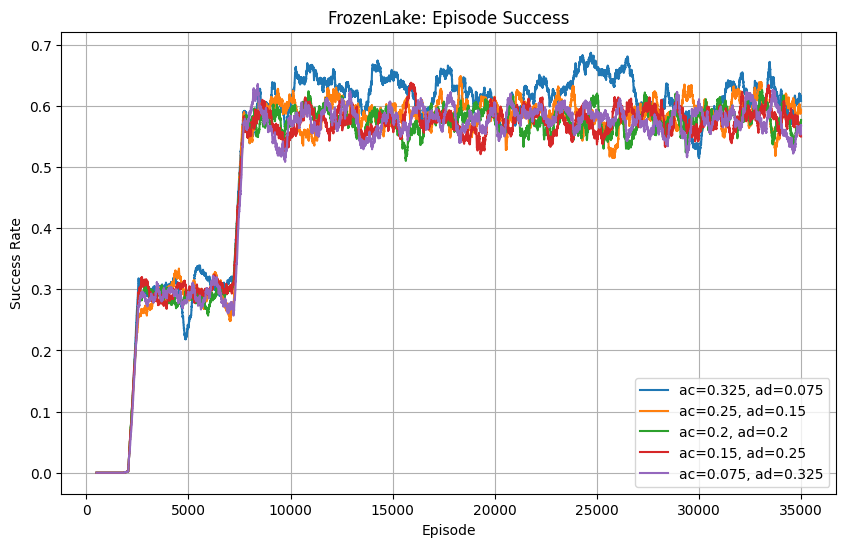

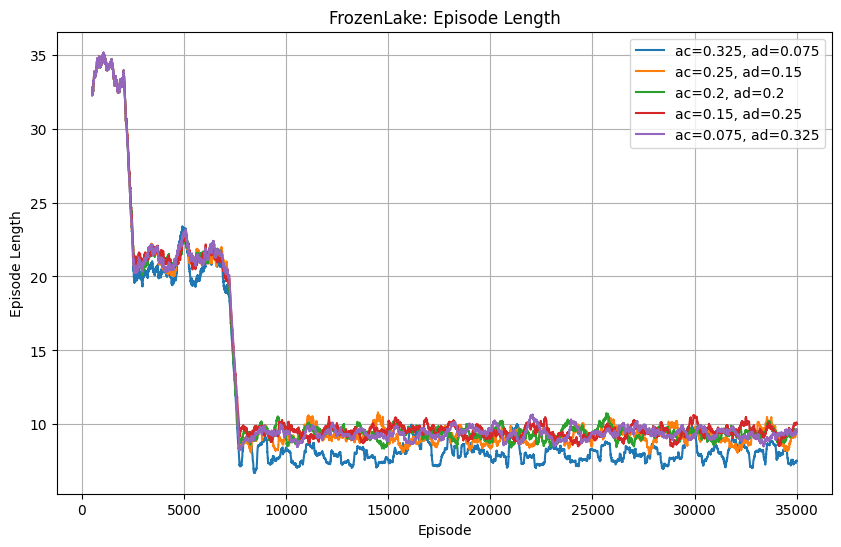

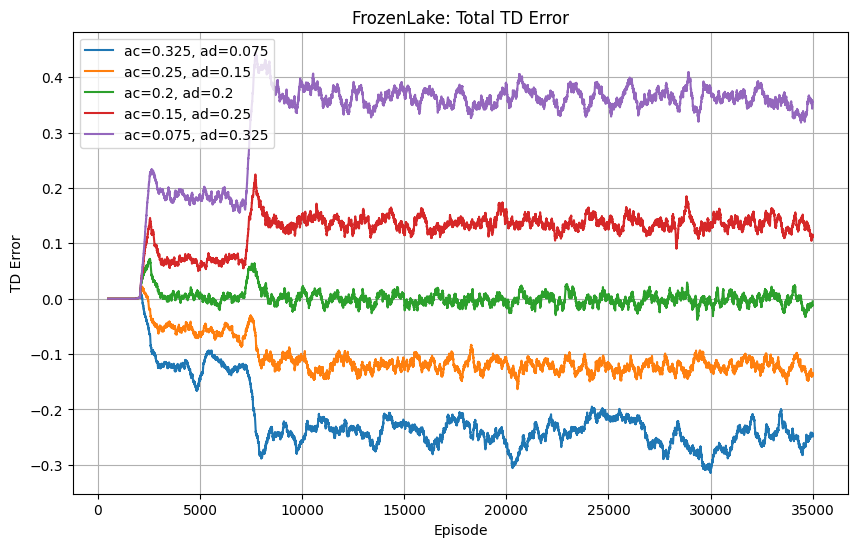

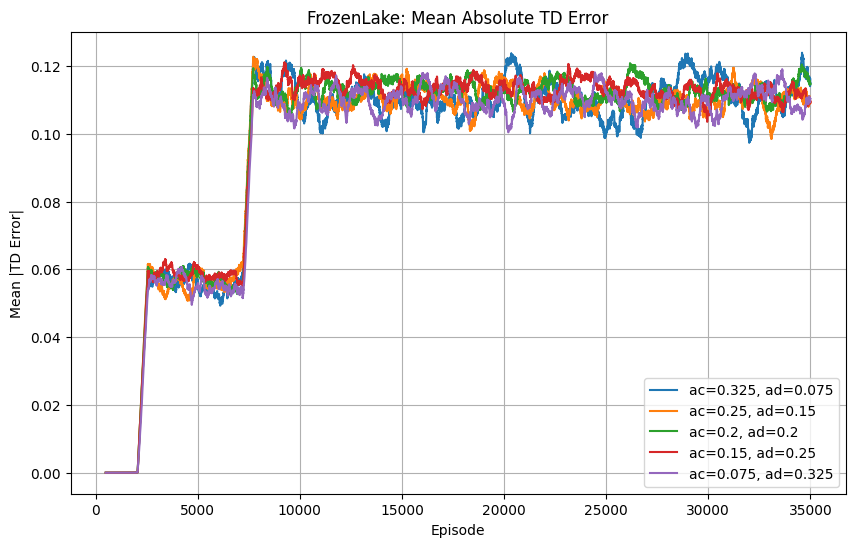

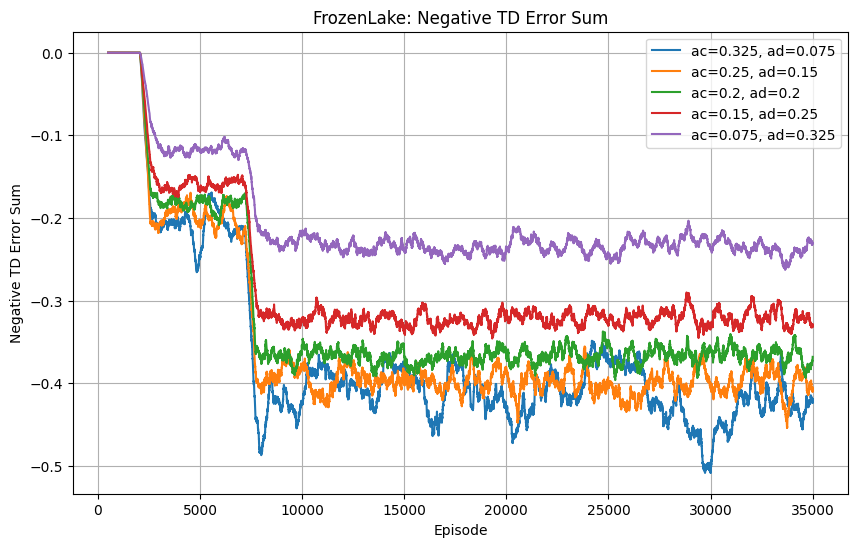

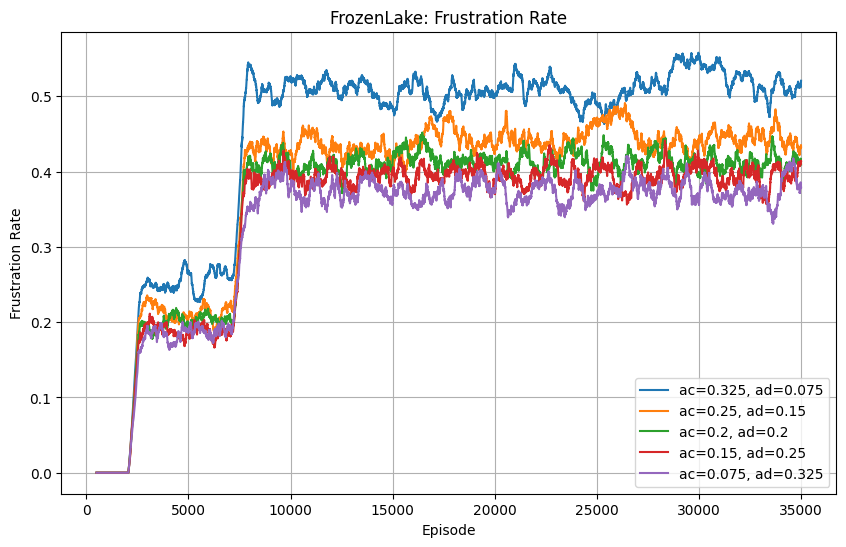

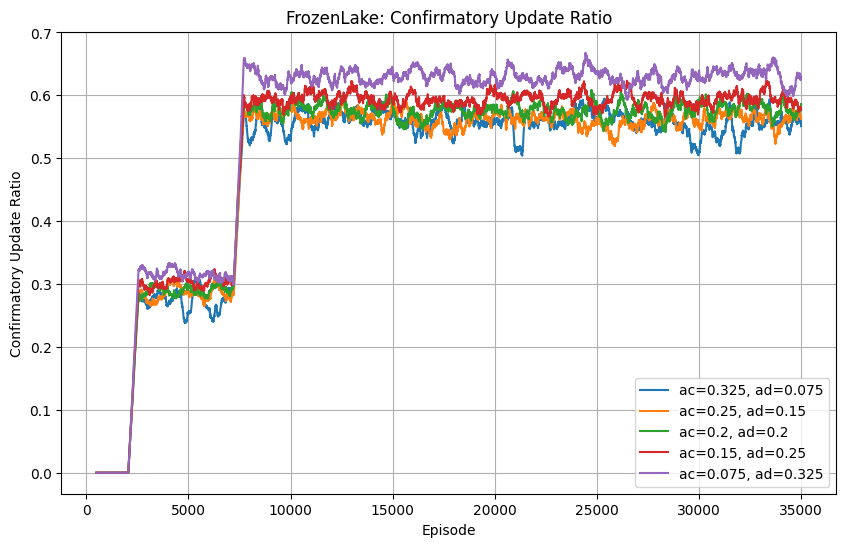

In [19]:
import importlib
from experiments.sweep_plots_helper import (
    frozenlake_training_plot_specs,
    frozenlake_evaluation_plot_specs,
)

import experiments.sweep_plots_helper_thesis as thesis_cfg_mod

importlib.reload(thesis_cfg_mod)
cfg = thesis_cfg_mod.frozenlake_training_thesis_config()


subset = select_results(
    results,
    ac_ad_pairs=[
        (0.325, 0.075),
        (0.25, 0.15),
        (0.2, 0.2),
        (0.15, 0.25),
        (0.075, 0.325),
    ],
)

plot_sweep_training(
    subset,
    window_size=500,
    label_fn=cfg["label_fn"],
    plot_specs=cfg["plot_specs"],
    start_episode=cfg["start_episode"],
    end_episode=cfg["end_episode"],
    use_td_error_v=cfg["use_td_error_v"],
)

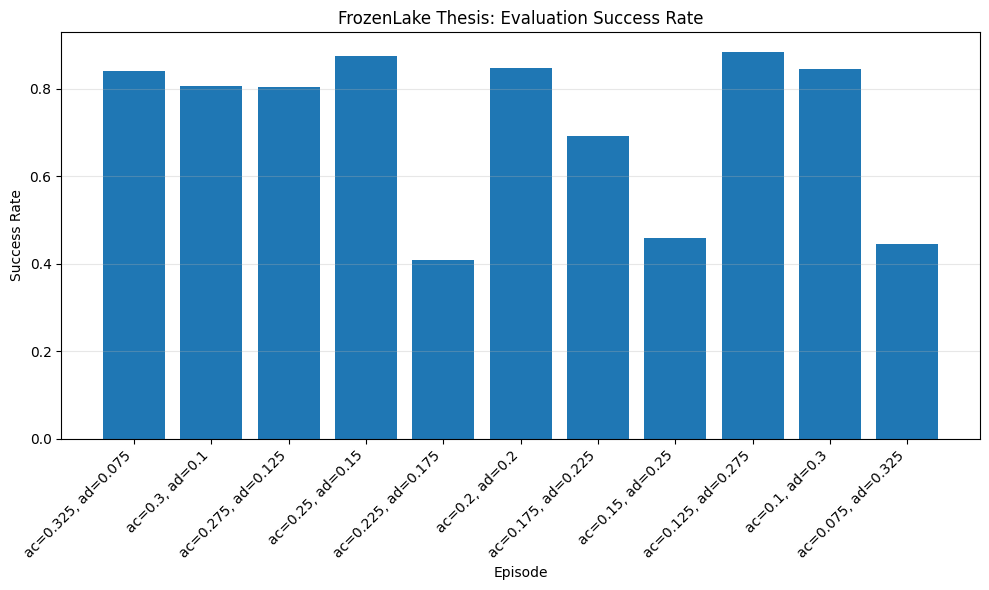

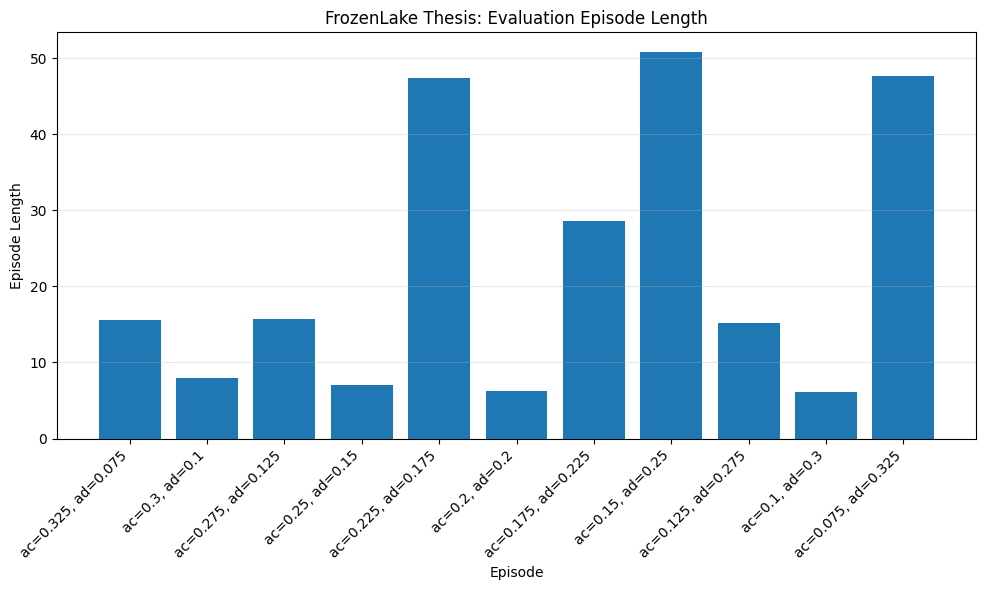

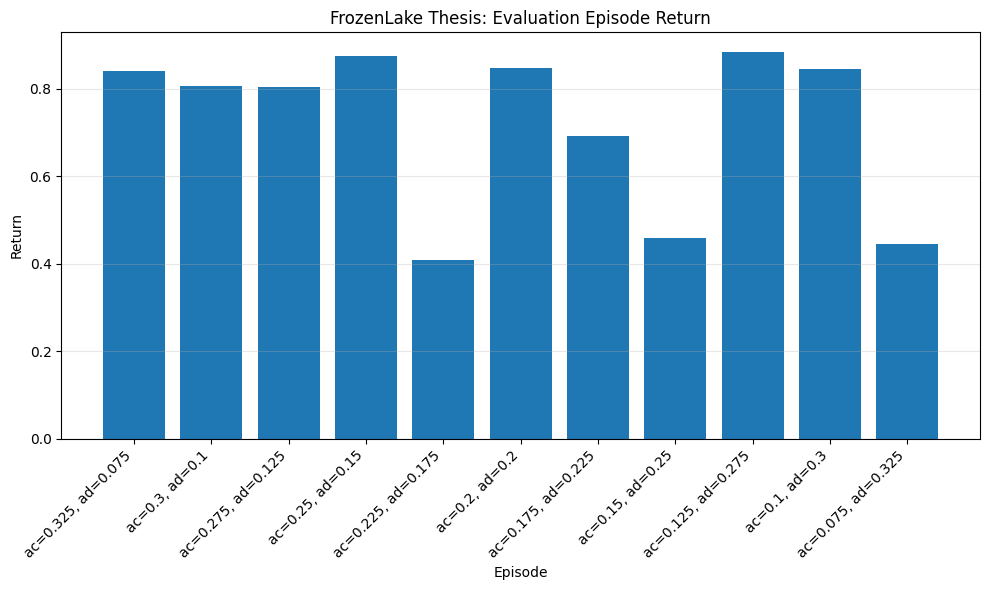

In [20]:
importlib.reload(thesis_cfg_mod)

cfg = thesis_cfg_mod.frozenlake_evaluation_thesis_config()

plot_sweep_evaluation(
    results,
    window_size=cfg["window_size"],
    label_fn=cfg["label_fn"],
    plot_specs=cfg["plot_specs"],
    start_episode=cfg["start_episode"],
    end_episode=cfg["end_episode"],
)

In [ ]:
plot_sweep_evaluation(
    results,
    window_size=100,
    plot_specs=frozenlake_evaluation_plot_specs(),
)

In [ ]:
# compare td_error vs td_error_v moving averages for one run
from plots.archive.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)


## Positivity bias results

In [ ]:
# SARSA positivty bias agent
from agents.sarsa_td0_positivity_bias import (
    SarsaTD0PositivityBiasConfig,
    SarsaTD0PositivityBiasAgent,
)

In [ ]:
def asymmetric_alphas(alpha_0: float, ratio: float) -> dict:
    """Return asymmetric step-sizes with a fixed mean and ratio."""
    if alpha_0 <= 0 or ratio <= 0:
        raise ValueError("alpha_0 and ratio must be > 0")

    alpha_negative = round((2.0 * alpha_0) / (ratio + 1.0), 4)
    alpha_positive = round(
        ratio * alpha_negative, 4
    )  # same as 2*alpha_0*ratio/(ratio+1)

    return {"alpha_positive": alpha_positive, "alpha_negative": alpha_negative}

In [ ]:
## Agents
# sarsa_td0 agent
agent_factory = SarsaTD0PositivityBiasAgent
sarsa_td0_config = SarsaTD0PositivityBiasConfig(**BASE_AGENT_CONFIG_POSITITY)

In [ ]:
base_train = TrainingConfig(
    name="FrozenLake_sarsa_td0",
    num_train_episodes=35000,
    env_kwargs={"config": env_config},
    agent_kwargs={"config": sarsa_td0_config},
)

base_eval = EvaluateConfig(
    name="FrozenLake_sarsa_td0",
    num_eval_episodes=5000,
    env_kwargs={"config": env_config},
    evaluation_metrics=frozenlake_reward_metrics_specs(),
)

In [ ]:
# different q_tables
env = get_frozenlake_env(env_config)
num_states = env.observation_space.n
num_actions = env.action_space.n
q0 = np.zeros((num_states, num_actions), dtype=np.float64)

In [ ]:
# mean alpha_0 = 0.2
a_0 = 0.2
ratios = [0.5, 0.75, 1.0, 1.5, 2.0, 4.0]

seeds = list(range(15))

sweep = {
    "agent_kwargs": [
        {
            **asymmetric_alphas(a_0, r),  # gives alpha_positive / alpha_negative
            "seed": seed,
            "initial_q_table": q0,
            "initial_q_table_label": "zeros",
        }
        for r in ratios
        for seed in seeds
    ],
}

In [ ]:
results_positivity = run_sweep(
    base_training=base_train,
    base_evaluation=base_eval,
    sweep=sweep,
    env_factory=get_frozenlake_env,
    agent_factory=agent_factory,
)

In [ ]:
plot_sweep_training(
    results_positivity, window_size=100, plot_specs=frozenlake_training_plot_specs()
)

In [ ]:
plot_sweep_evaluation(
    results_positivity, window_size=100, plot_specs=frozenlake_evaluation_plot_specs()
)

In [ ]:
# compare td_error vs td_error_v moving averages for one run
from plots.td_error_plots import (
    plot_moving_average_td_errors_multi,
    plot_moving_average_td_errors_neg_multi,
)

run_index = 0
td_error_metrics = results[run_index]["training"]["td_error"]
td_errors = td_error_metrics.get("total_td_error_per_episode")
td_errors_v = td_error_metrics.get("total_td_error_per_episode_v")
if td_errors is None or td_errors_v is None:
    raise ValueError("Missing td_error series; check metrics keys.")

plot_moving_average_td_errors_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)
plot_moving_average_td_errors_neg_multi(
    {"td_error": td_errors, "td_error_v": td_errors_v}, window=100
)